In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import json
import gzip
import codecs
import os
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
model_path = "data/models/a5_tseries_model_2hr.h5"
bed_path = "data/a5/tseries/2hr/2hr.bed.gz"

In [3]:
fastapath = "data/genome/hg38/hg38.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

seq_len = 1346
out_pred_len = 1000
test_chrms = ["chr1", "chr8", "chr21"]
peaks = []
with gzip.open(bed_path, 'rt') as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + int(line.strip().split('\t')[-1])
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        peaks.append(GenomeDict[chrm][start:end].upper())

In [4]:
from deeplift.dinuc_shuffle import dinuc_shuffle

def fill_into_center(seq, insert):
    flank = int((len(seq)-len(insert))/2.0)
    new_seq = seq[:flank]
    for nuc_id, nuc in enumerate(insert):
        if nuc == 'N':
            new_seq += seq[flank+nuc_id]
        else:
            new_seq += nuc
    new_seq += seq[flank+len(insert):]
    return new_seq

ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [5]:
num_samples = 100
indices = np.random.choice(len(peaks), num_samples, replace=False)
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model(model_path)

allo_seq = "AGAACATCATGTTCT"
yvals = []
intervals = [7,9,11,13,15,16,17,19,21,23,26]
for n in intervals:
    pre_seqs = []
    post_seqs = []    
    for idx in indices:
        pre_seq = dinuc_shuffle(peaks[idx])
        post_seq = fill_into_center(pre_seq, allo_seq+(n*'N')+'AGAACATCATGTTCT')
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals.append(-np.mean(post[0]-pre[0]))

yvals2 = []
for n in intervals:
    pre_seqs = []
    post_seqs = []
    for idx in indices:
        pre_seq = dinuc_shuffle(peaks[idx])
        post_seq = fill_into_center(pre_seq, allo_seq+(n*'N')+'AGAACATGATGTTCT')
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals2.append(-np.mean(post[0]-pre[0]))







Instructions for updating:
Use `tf.cast` instead.


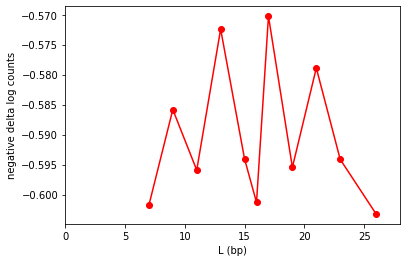

In [6]:
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.plot(intervals, yvals, marker="o", c="red")
plt.xlim((0,28))
plt.xlabel("L (bp)")
plt.ylabel("negative delta log counts")
plt.show()

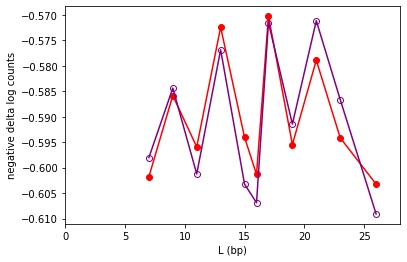

In [7]:
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.plot(intervals, yvals, marker="o", c="red")
ax.plot(intervals, yvals2, marker="o", markerfacecolor='none', c='purple')
plt.xlim((0,28))
plt.xlabel("L (bp)")
plt.ylabel("negative delta log counts")
plt.show()

In [8]:
yvals = []
intervals = list(range(0,100))
for n in intervals:
    pre_seqs = []
    post_seqs = []    
    for idx in indices:
        pre_seq = dinuc_shuffle(peaks[idx])
        post_seq = fill_into_center(pre_seq, allo_seq+(n*'N')+'AGAACATCATGTTCT')
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals.append(-np.mean(post[0]-pre[0]))

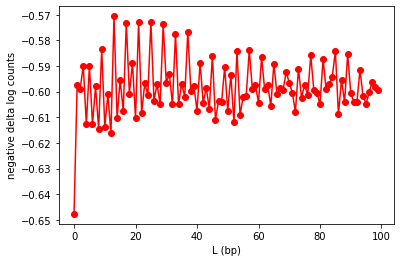

In [9]:
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.plot(intervals, yvals, marker="o", c="red")
plt.xlabel("L (bp)")
plt.ylabel("negative delta log counts")
plt.show()

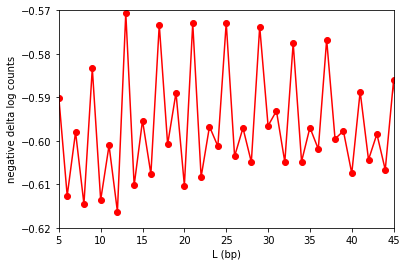

In [10]:
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.plot(intervals, yvals, marker="o", c="red")
plt.xlim((5,45))
plt.ylim((-0.62, -0.57))
plt.xlabel("L (bp)")
plt.ylabel("negative delta log counts")
plt.show()

In [11]:
yvals = []
linkSeq = 100*'GC'
intervals = list(range(5,46))
for n in intervals:
    pre_seqs = []
    post_seqs = []    
    for idx in indices:
        pre_seq = dinuc_shuffle(peaks[idx])
        post_seq = fill_into_center(pre_seq, allo_seq+linkSeq[:n]+'AGAACATCATGTTCT')
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals.append(-np.mean(post[0]-pre[0]))

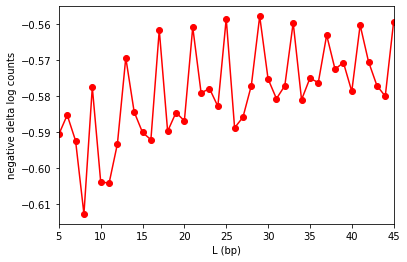

In [12]:
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.plot(intervals, yvals, marker="o", c="red")
plt.xlim((5,45))
plt.xlabel("L (bp)")
plt.ylabel("negative delta log counts")
plt.show()

In [13]:
yvals = []
linkSeq = 100*'AN'
intervals = list(range(5,46))
for n in intervals:
    pre_seqs = []
    post_seqs = []    
    for idx in indices:
        pre_seq = dinuc_shuffle(peaks[idx])
        post_seq = fill_into_center(pre_seq, allo_seq+linkSeq[:n]+'AGAACATCATGTTCT')
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals.append(-np.mean(post[0]-pre[0]))

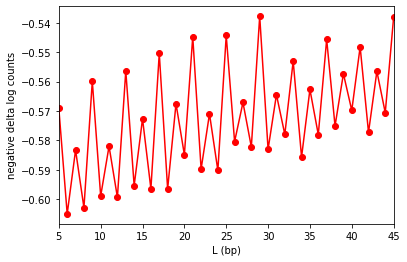

In [14]:
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.plot(intervals, yvals, marker="o", c="red")
plt.xlim((5,45))
plt.xlabel("L (bp)")
plt.ylabel("negative delta log counts")
plt.show()

In [15]:
yvals = []
linkSeq = 100*'AT'
intervals = list(range(5,46))
for n in intervals:
    pre_seqs = []
    post_seqs = []    
    for idx in indices:
        pre_seq = dinuc_shuffle(peaks[idx])
        post_seq = fill_into_center(pre_seq, allo_seq+linkSeq[:n]+'AGAACATCATGTTCT')
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals.append(-np.mean(post[0]-pre[0]))

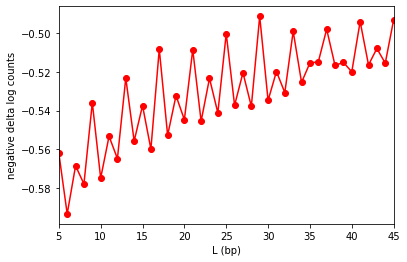

In [16]:
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.plot(intervals, yvals, marker="o", c="red")
plt.xlim((5,45))
plt.xlabel("L (bp)")
plt.ylabel("negative delta log counts")
plt.show()